<a href="https://colab.research.google.com/github/xRozzo/FTP-Server/blob/main/Introduction_to_defi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycoingecko
!pip install matplotlib

## Get the data

In [ ]:
from pycoingecko import CoinGeckoAPI
from google.colab import userdata
import pandas as pd
import numpy as np
from math import sqrt


coingecko_key = userdata.get('cg_key')


ticker = "bitcoin"
period = 730 # 2years aprox
window = 20 # example
year_total_days = 365 # total trading days 1 year
cg = CoinGeckoAPI(api_key=coingecko_key)

data = cg.get_coin_market_chart_by_id(id=ticker, vs_currency="usd", days=period)

# format data
prices = data["prices"]
df = pd.DataFrame(prices, columns=["timestamp", "price"])
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
df["Return"] = np.log(df["price"] / df["price"].shift(1)) # todays / yesterday price
df["RealizedVol20d"] = df["Return"].rolling(window).std() * sqrt(year_total_days)

# save df as csv
df.to_csv(f"bitcoin_{period}.csv")


## Crete our signal

In [ ]:
# from the data create a signal (example momentum)
# ideate here (long/short signals for simplicity)
# 1 long and -1 for short
# you can add 0 to represent cash out (not having a position)

df = pd.read_csv("./bitcoin_730.csv")

df["signal"] = np.where(df["price"] > df["price"].shift(window), 1, -1)
print(df["signal"])


df.to_csv(f"bitcoin_{period}_signal.csv")





0     -1
1     -1
2     -1
3     -1
4     -1
      ..
726   -1
727   -1
728   -1
729   -1
730   -1
Name: signal, Length: 731, dtype: int64


## Conclusion from our results



In [ ]:
# compute strategy returns
df["strategy_returns"] =  df["signal"].shift(1) * df["Return"]


# compute -> why the squre root for the anualize, also exp we know from log to normal

mu_strat = df["strategy_returns"].mean()
sd_strat = df["strategy_returns"].std()
mu_market = df["Return"].std()
sd_market = df["strategy_returns"].std()

sharpe_strat = mu_strat / sd_strat
sharpe_market = mu_market / sd_market

sharpe_strat_anualized = sharpe_strat * (year_total_days ** 0.5)
sharpe_marke_anualized = sharpe_market * (year_total_days ** 0.5)


cumulative_returns_srat = np.exp(df["strategy_returns"].sum()) - 1
cumulative_returns_market = np.exp(df["Return"].sum()) - 1

total_years = period / year_total_days

strat_apy = cumulative_returns_srat / total_years
market_apy = cumulative_returns_market / total_years

print("------------------------ RESULTS ------------------------")

print("Sharpe strat: ", sharpe_strat)
print("Sharpe market: ", sharpe_market)
print("Long only strat results (APY): ", market_apy)
print("Momentum long/short strat (APY): ", strat_apy)
print("---------------------------------------------------------")


------------------------ RESULTS ------------------------
Sharpe strat:  0.036873535261544736
Sharpe market:  0.9988358690972318
Long only strat results (APY):  1.015659799573316
Momentum long/short strat (APY):  0.48082581278434566
---------------------------------------------------------


## Strategy visualization

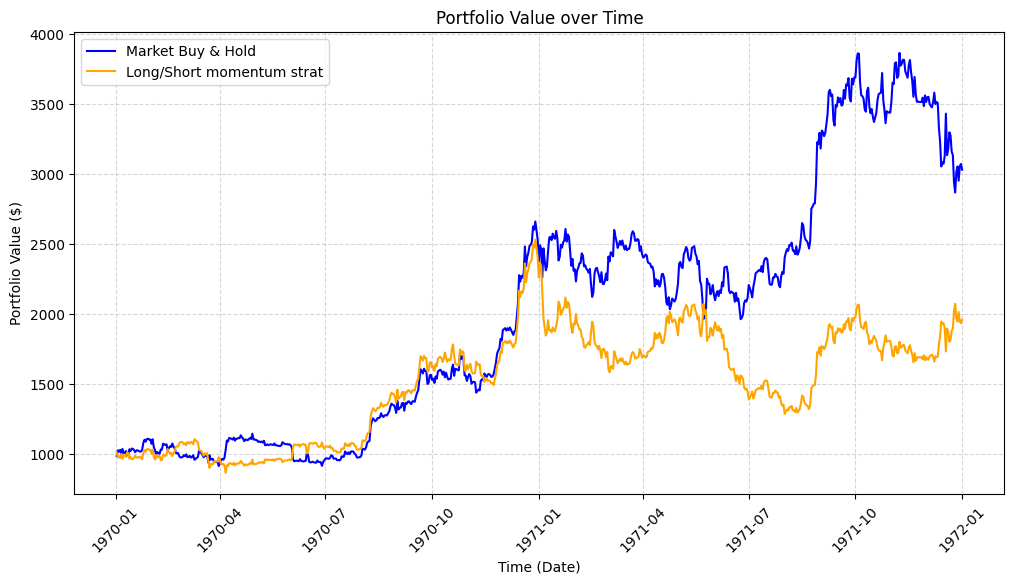

In [ ]:
# simple portfolio visualization and compare to market
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

portfolio_value = 1000  # Example USD

# Sort values by timestamp
df = df.sort_values("timestamp")

# Calculate cumulative returns
df["market_value"] = portfolio_value * np.exp(df["Return"].cumsum())
df["strategy_value"] = portfolio_value * np.exp(df["strategy_returns"].cumsum())

# Plot the portfolio values
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df["timestamp"], df["market_value"], label="Market Buy & Hold", color="blue")
ax1.plot(df["timestamp"], df["strategy_value"], label="Long/Short momentum strat", color="orange")
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto spacing of dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  # Format to show Year-Month

# Labeling
ax1.set_xlabel("Time (Date)")
ax1.set_ylabel("Portfolio Value ($)")
ax1.set_title("Portfolio Value over Time")
ax1.legend(loc="upper left")
ax1.set_facecolor("white")
ax1.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)

plt.show()


## Have in mind that..


- This is just and example with really low data
- The real process is way more extense and diverse
